### Imports

In [1]:
import cv2
import gymnasium as gym
from tetris_gymnasium.envs.tetris import Tetris
from tetris_gymnasium.mappings.rewards import RewardsMapping
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

### Testing with random actions

In [2]:
env = gym.make("tetris_gymnasium/Tetris", render_mode="human")

env.reset()

terminated = False
while not terminated:
    env.render()
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    key = cv2.waitKey(100) 
env.close()
cv2.destroyAllWindows()

In [16]:
env.close()
cv2.destroyAllWindows()

### Extraction function that creates a state from board array

In [3]:
def extract_features(obs, env):
    board = obs["board"]


    # 1) Crop to the playable area (20 rows, 10 columns):
    cropped = board[:env.unwrapped.height, env.unwrapped.padding:-env.unwrapped.padding]


    # 2) Compute raw features: column heights, holes, bumpiness, total_height
    heights = []
    holes = 0
    for col_i in range(cropped.shape[1]):
        col = cropped[:, col_i]
        filled_idx = np.where(col > 1)[0]
        if len(filled_idx) == 0:
            h = 0
        else:
            h = cropped.shape[0] - filled_idx[0]  # height from bottom
        heights.append(h)
        if len(filled_idx) > 0:
            holes_col = np.count_nonzero(col[filled_idx[0]:] == 0)
            holes += holes_col


    bumpiness = sum(abs(heights[i] - heights[i+1]) for i in range(len(heights)-1))
    total_height = sum(heights)


    # --- BINNING SECTION ---
    # fewer thresholds => fewer bins
    height_bins = [7, 14]        # => 3 bins
    holes_bins = [5, 10]         # => 3 bins
    bumpiness_bins = [10, 20]    # => 3 bins
    total_height_bins = [20, 40] # => 3 bins


    def bin_value(x, thresholds):
        for i, th in enumerate(thresholds):
            if x < th:
                return i
        return len(thresholds)


    binned_heights = tuple(bin_value(h, height_bins) for h in heights)
    holes_bin = bin_value(holes, holes_bins)
    bumpiness_bin = bin_value(bumpiness, bumpiness_bins)
    total_height_bin = bin_value(total_height, total_height_bins)


    return (binned_heights, holes_bin, bumpiness_bin, total_height_bin)

### Sarsa

In [ ]:
class SARSA(object):
    def __init__(self, env, alpha, epsilon, gamma, timeout):
        # definte the parameters
        self.alpha = alpha 
        self.epsilon = epsilon
        self.gamma = gamma
        self.timeout = timeout

        # environment
        self.env = env

        # define the Q value table
        self.Q = defaultdict(lambda: defaultdict(float))

    def behavior_policy(self, state):

        # explore
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        
        # new state
        if state not in self.Q or not self.Q[state]:
            return self.env.action_space.sample()
        
        # exploit
        return max(self.Q[state], key=self.Q[state].get)
        
    def update(self, s, a, r, s_prime, a_prime):

        # update the Q value table using the SARSA update rule
        self.Q[s][a] += self.alpha * (r + self.gamma * self.Q[s_prime][a_prime] - self.Q[s][a])

    def train(self, num_episodes):

        # initialize rewards
        rewards = []

        # initialize alpha and epsilon decay
        alpha_decay = (0.001 / self.alpha) ** (1 / num_episodes)
        epsilon_decay = (0.01 / self.epsilon) ** (1 / num_episodes)

        # train the agent for a number of episodes
        for episode in range(num_episodes):

            # epsilon decay
            self.epsilon = max(0.01, self.epsilon * epsilon_decay)

            # alpha decay
            self.alpha = max(0.001, self.alpha * alpha_decay)

            # reset the environment
            obs, info = self.env.reset()
            state = extract_features(obs, self.env)

            # get the first action
            action = self.behavior_policy(state)

            # initialize the reward
            episode_reward = 0

            for t in range(self.timeout):

                # render the environment every 10000 episodes
                if episode % 10000 == 0:
                    self.env.render()
                    cv2.waitKey(100)

                # take the action
                next_obs, reward, terminated, truncated, info = self.env.step(action)
                next_state = extract_features(next_obs, self.env)

                # get the next action
                next_action = self.behavior_policy(next_state)

                # update the Q value table
                self.update(state, action, reward, next_state, next_action)

                # update the state, action, and reward
                state = next_state
                action = next_action
                episode_reward += reward

                # if the game is over, reset the environment
                if terminated or truncated:
                    break

            # append the reward to the list of rewards
            rewards.append(episode_reward)

            # print the average reward every 100 episodes
            if episode % 100 == 0:
                avg_reward = np.mean(rewards[-100:])
                print(f"Episode {episode}, Average Reward: {avg_reward}")

        return rewards

In [7]:
# CUSTOM REWARDS MAPPING
rewards = RewardsMapping(
    alife=2.0,
    clear_line=1.0,
    game_over=-20.0,
    invalid_action=-0.1,
)

In [ ]:
env = gym.make("tetris_gymnasium/Tetris", render_mode="human", rewards_mapping=rewards)
agent = SARSA(env, alpha=0.1, epsilon=0.3, gamma=0.99, timeout=1000)

reward_records = agent.train(num_episodes=1000000)

env.close()
cv2.destroyAllWindows()

Episode 0, Average Reward: -2.0
Episode 100, Average Reward: 0.18
Episode 200, Average Reward: 0.54
Episode 300, Average Reward: 0.62
Episode 400, Average Reward: 0.18
Episode 500, Average Reward: -0.56
Episode 600, Average Reward: -0.56
Episode 700, Average Reward: -1.66
Episode 800, Average Reward: -2.14
Episode 900, Average Reward: -1.84
Episode 1000, Average Reward: -1.06
Episode 1100, Average Reward: -1.14
Episode 1200, Average Reward: -0.52
Episode 1300, Average Reward: -1.98
Episode 1400, Average Reward: -1.16
Episode 1500, Average Reward: -1.32
Episode 1600, Average Reward: -1.92
Episode 1700, Average Reward: -0.48
Episode 1800, Average Reward: 0.14
Episode 1900, Average Reward: 3.36
Episode 2000, Average Reward: -1.74
Episode 2100, Average Reward: -0.44
Episode 2200, Average Reward: -1.0
Episode 2300, Average Reward: 1.32
Episode 2400, Average Reward: -1.94
Episode 2500, Average Reward: -0.96
Episode 2600, Average Reward: 0.4
Episode 2700, Average Reward: -1.2
Episode 2800, Av

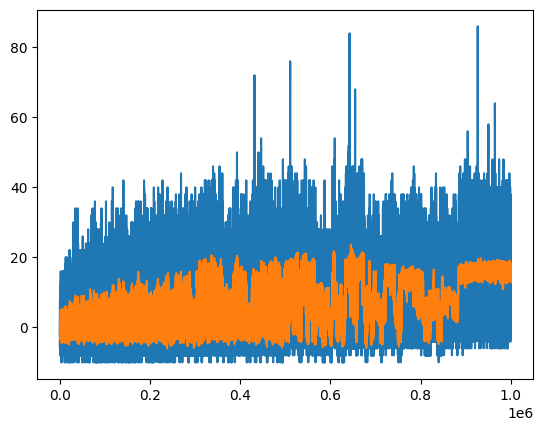

In [8]:
# FROM CS5180 EXERCISE 7

# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int) 
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)

### Q-learning

In [8]:
class QLearning(object):
    def __init__(self, env, alpha, epsilon, gamma, timeout):
        # definte the parameters
        self.alpha = alpha 
        self.epsilon = epsilon
        self.gamma = gamma
        self.timeout = timeout

        # environment
        self.env = env

        # define the Q value table
        self.Q = defaultdict(lambda: defaultdict(float))

    def behavior_policy(self, state):
        
        # explore
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        
        # new state
        if state not in self.Q or not self.Q[state]:
            return self.env.action_space.sample()
        
        # exploit
        return max(self.Q[state], key=self.Q[state].get)
    
    def update(self, s, a, r, s_prime):

        # update the Q value table using the Q-learning update rule
        if s_prime not in self.Q or not self.Q[s_prime]:
            max_q = 0
        else:
            max_q = max(self.Q[s_prime].values())

        self.Q[s][a] += self.alpha * (r + self.gamma * max_q - self.Q[s][a])

    def train(self, num_episodes):

        # initialize rewards
        rewards = []

        # initialize alpha and epsilon decay
        alpha_decay = (0.001 / self.alpha) ** (1 / num_episodes)
        epsilon_decay = (0.01 / self.epsilon) ** (1 / num_episodes)

        # train the agent for a number of episodes
        for episode in range(num_episodes):

            # epsilon decay
            self.epsilon = max(0.01, self.epsilon * epsilon_decay)

            # alpha decay
            self.alpha = max(0.001, self.alpha * alpha_decay)

            # reset the environment
            obs, info = self.env.reset()
            state = extract_features(obs, self.env)

            # get the first action
            action = self.behavior_policy(state)

            # initialize the reward
            episode_reward = 0

            for t in range(self.timeout):

                # render the environment every 10000 episodes
                if episode % 10000 == 0:
                    self.env.render()
                    cv2.waitKey(100)

                # take the action
                next_obs, reward, terminated, truncated, info = self.env.step(action)
                next_state = extract_features(next_obs, self.env)

                # update the Q value table
                self.update(state, action, reward, next_state)

                # update the state, action, and reward
                state = next_state
                action = self.behavior_policy(state)
                episode_reward += reward

                # if the game is over, reset the environment
                if terminated or truncated:
                    break

            # append the reward to the list of rewards
            rewards.append(episode_reward)

            # print the average reward every 100 episodes
            if episode % 100 == 0:
                avg_reward = np.mean(rewards[-100:])
                print(f"Episode {episode}, Average Reward: {avg_reward}")

        return rewards

In [9]:
env = gym.make("tetris_gymnasium/Tetris", render_mode="human", rewards_mapping=rewards)
agent = QLearning(env, alpha=0.1, epsilon=0.3, gamma=0.99, timeout=1000)

reward_records = agent.train(num_episodes=1000000)

env.close()
cv2.destroyAllWindows()

Episode 0, Average Reward: 0.0
Episode 100, Average Reward: -1.2
Episode 200, Average Reward: -1.36
Episode 300, Average Reward: -2.64
Episode 400, Average Reward: -1.74
Episode 500, Average Reward: -2.3
Episode 600, Average Reward: -0.98
Episode 700, Average Reward: -1.0
Episode 800, Average Reward: -1.06
Episode 900, Average Reward: -1.28
Episode 1000, Average Reward: -2.56
Episode 1100, Average Reward: -2.1
Episode 1200, Average Reward: -1.84
Episode 1300, Average Reward: -1.14
Episode 1400, Average Reward: -2.04
Episode 1500, Average Reward: -2.32
Episode 1600, Average Reward: -3.1
Episode 1700, Average Reward: -2.96
Episode 1800, Average Reward: -2.32
Episode 1900, Average Reward: -2.66
Episode 2000, Average Reward: -3.02
Episode 2100, Average Reward: -2.16
Episode 2200, Average Reward: -3.18
Episode 2300, Average Reward: -2.52
Episode 2400, Average Reward: -2.64
Episode 2500, Average Reward: -2.66
Episode 2600, Average Reward: -2.46
Episode 2700, Average Reward: -2.64
Episode 280

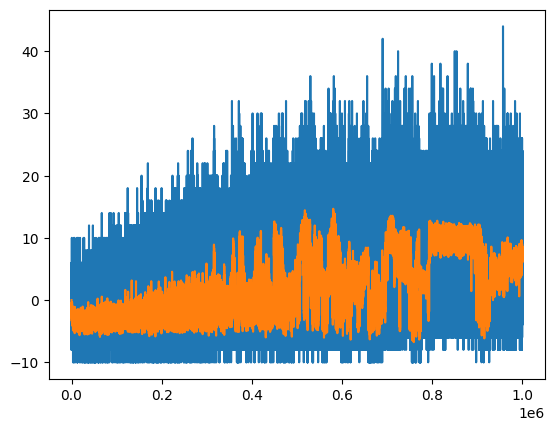

In [10]:
# FROM CS5180 EXERCISE 7

# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int) 
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)

### Expected Sarsa

In [17]:
class ExpectedSARSA(object):
    def __init__(self, env, alpha, epsilon, gamma, timeout):
        # definte the parameters
        self.alpha = alpha 
        self.epsilon = epsilon
        self.gamma = gamma
        self.timeout = timeout

        # environment
        self.env = env

        # define the Q value table
        self.Q = defaultdict(lambda: defaultdict(float))

    def behavior_policy(self, state):
        
        # explore
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        
        # new state
        if state not in self.Q or not self.Q[state]:
            return self.env.action_space.sample()
        
        # exploit
        return max(self.Q[state], key=self.Q[state].get)
    
    def expected_value(self, state):

        # get action space and number of actions
        action_space = range(self.env.action_space.n)
        n_actions = len(action_space)

        # if state is not in Q or has no actions, return 0.0
        if state not in self.Q or not self.Q[state]:
            return 0.0

        # get the Q values for the state and find the greedy actions
        q_vals = self.Q[state]
        max_q = max(q_vals.values())
        greedy_actions = [a for a in action_space if q_vals[a] == max_q]

        # calculate the expected value
        expected = 0.0
        for a in action_space:
            if a in greedy_actions:
                prob = ((1 - self.epsilon) / len(greedy_actions)) + (self.epsilon / n_actions)
            else:
                prob = self.epsilon / n_actions
            expected += prob * q_vals.get(a, 0.0)

        return expected
    
    def update(self, s, a, r, s_prime):

        # update the Q value table using the Expected SARSA update rule
        expected_value = self.expected_value(s_prime)
        self.Q[s][a] += self.alpha * (r + self.gamma * expected_value - self.Q[s][a])

    def train(self, num_episodes):

        # initialize rewards
        rewards = []

        # initialize alpha and epsilon decay
        alpha_decay = (0.001 / self.alpha) ** (1 / num_episodes)
        epsilon_decay = (0.01 / self.epsilon) ** (1 / num_episodes)

        # train the agent for a number of episodes
        for episode in range(num_episodes):

            # epsilon decay
            self.epsilon = max(0.01, self.epsilon * epsilon_decay)

            # alpha decay
            self.alpha = max(0.001, self.alpha * alpha_decay)

            # reset the environment
            obs, info = self.env.reset()
            state = extract_features(obs, self.env)

            # get the first action
            action = self.behavior_policy(state)

            # initialize the reward
            episode_reward = 0

            for t in range(self.timeout):

                # render the environment every 10000 episodes
                if episode % 10000 == 0:
                    self.env.render()
                    cv2.waitKey(100)

                # take the action
                next_obs, reward, terminated, truncated, info = self.env.step(action)
                next_state = extract_features(next_obs, self.env)

                # update the Q value table
                self.update(state, action, reward, next_state)

                # update the state, action, and reward
                state = next_state
                action = self.behavior_policy(state)
                episode_reward += reward

                # if the game is over, reset the environment
                if terminated or truncated:
                    break

            # append the reward to the list of rewards
            rewards.append(episode_reward)

            # print the average reward every 100 episodes
            if episode % 100 == 0:
                avg_reward = np.mean(rewards[-100:])
                print(f"Episode {episode}, Average Reward: {avg_reward}")

        return rewards

In [ ]:
env = gym.make("tetris_gymnasium/Tetris", render_mode="human", rewards_mapping=rewards)
agent = ExpectedSARSA(env, alpha=0.1, epsilon=0.3, gamma=0.99, timeout=1000)

reward_records = agent.train(num_episodes=1000000)

env.close()
cv2.destroyAllWindows()

Episode 0, Average Reward: 0.0
Episode 100, Average Reward: -0.2
Episode 200, Average Reward: 0.32
Episode 300, Average Reward: -0.66
Episode 400, Average Reward: -0.1
Episode 500, Average Reward: 2.14
Episode 600, Average Reward: 1.06
Episode 700, Average Reward: -1.4
Episode 800, Average Reward: -1.84
Episode 900, Average Reward: 0.1
Episode 1000, Average Reward: -0.22
Episode 1100, Average Reward: -1.3
Episode 1200, Average Reward: -1.86
Episode 1300, Average Reward: -2.28
Episode 1400, Average Reward: 2.36
Episode 1500, Average Reward: 0.66
Episode 1600, Average Reward: 0.0
Episode 1700, Average Reward: 1.2
Episode 1800, Average Reward: -0.86
Episode 1900, Average Reward: 0.3
Episode 2000, Average Reward: -1.84
Episode 2100, Average Reward: 2.4
Episode 2200, Average Reward: -1.18
Episode 2300, Average Reward: -0.52
Episode 2400, Average Reward: -0.72
Episode 2500, Average Reward: -1.24
Episode 2600, Average Reward: -1.44
Episode 2700, Average Reward: -0.8
Episode 2800, Average Rewa

In [ ]:
# FROM CS5180 EXERCISE 7

# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int) 
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)

### Double Q-learning

In [ ]:
class DoubleQLearning(object):
    def __init__(self, env, alpha, epsilon, gamma, timeout):
        # definte the parameters
        self.alpha = alpha 
        self.epsilon = epsilon
        self.gamma = gamma
        self.timeout = timeout

        # environment
        self.env = env

        # define the Q value table
        self.Q1 = defaultdict(lambda: defaultdict(float))
        self.Q2 = defaultdict(lambda: defaultdict(float))

    def behavior_policy(self, state):
        
        # explore
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        
        # new state
        if state not in self.Q1 and state not in self.Q2 or (not self.Q1[state] and not self.Q2[state]):
            return self.env.action_space.sample()
        
        # exploit
        if state in self.Q1 and state in self.Q2:
            q1 = self.Q1[state]
            q2 = self.Q2[state]
            max_q = max(q1, q2, key=lambda x: max(q1[x], q2[x]))
            return max_q
        elif state in self.Q1:
            return max(self.Q1[state], key=self.Q1[state].get)
        else:
            return max(self.Q2[state], key=self.Q2[state].get)
        
    def update(self, s, a, r, s_prime):
            
            # update the Q value table using the Double Q-learning update rule
            if np.random.rand() < 0.5:

                # update Q1
                max_a = max(self.Q2[s_prime], key=self.Q2[s_prime].get)
                self.Q1[s][a] += self.alpha * (r + self.gamma * self.Q2[s_prime][max_a] - self.Q1[s][a])

            else:

                # update Q2
                max_a = max(self.Q1[s_prime], key=self.Q1[s_prime].get)
                self.Q2[s][a] += self.alpha * (r + self.gamma * self.Q1[s_prime][max_a] - self.Q2[s][a])

    def train(self, num_episodes):

        # initialize rewards
        rewards = []

        # initialize alpha and epsilon decay
        alpha_decay = (0.001 / self.alpha) ** (1 / num_episodes)
        epsilon_decay = (0.01 / self.epsilon) ** (1 / num_episodes)

        # train the agent for a number of episodes
        for episode in range(num_episodes):

            # epsilon decay
            self.epsilon = max(0.01, self.epsilon * epsilon_decay)

            # alpha decay
            self.alpha = max(0.001, self.alpha * alpha_decay)

            # reset the environment
            obs, info = self.env.reset()
            state = extract_features(obs, self.env)

            # get the first action
            action = self.behavior_policy(state)

            # initialize the reward
            episode_reward = 0

            for t in range(self.timeout):

                # render the environment every 10000 episodes
                if episode % 10000 == 0:
                    self.env.render()
                    cv2.waitKey(100)

                # take the action
                next_obs, reward, terminated, truncated, info = self.env.step(action)
                next_state = extract_features(next_obs, self.env)

                # update the Q value table
                self.update(state, action, reward, next_state)

                # update the state, action, and reward
                state = next_state
                action = self.behavior_policy(state)
                episode_reward += reward

                # if the game is over, reset the environment
                if terminated or truncated:
                    break

            # append the reward to the list of rewards
            rewards.append(episode_reward)

            # print the average reward every 100 episodes
            if episode % 100 == 0:
                avg_reward = np.mean(rewards[-100:])
                print(f"Episode {episode}, Average Reward: {avg_reward}")

        return rewards


In [ ]:
env = gym.make("tetris_gymnasium/Tetris", render_mode="human", rewards_mapping=rewards)
agent = DoubleQLearning(env, alpha=0.1, epsilon=0.3, gamma=0.99, timeout=1000)

reward_records = agent.train(num_episodes=1000000)

env.close()
cv2.destroyAllWindows()

In [ ]:
# FROM CS5180 EXERCISE 7

# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int) 
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)